In [1]:
from main import training
from main import DQN, DQN1, DQN2, DQN3, DQN4

Using Device: cuda


# Model selection

<Figure size 432x288 with 0 Axes>

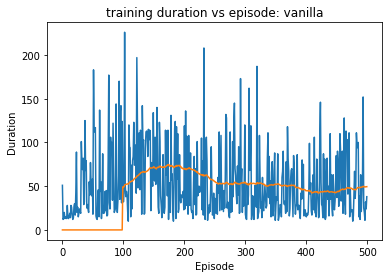

Training Completed for episods


<Figure size 432x288 with 0 Axes>

In [10]:
training(model = DQN)

<Figure size 432x288 with 0 Axes>

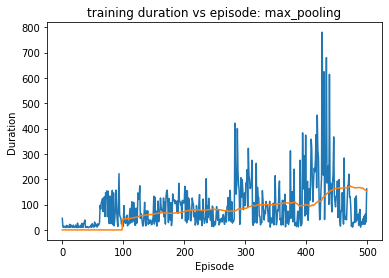

Training Completed for episods


<Figure size 432x288 with 0 Axes>

In [4]:
training(model = DQN1)


<Figure size 432x288 with 0 Axes>

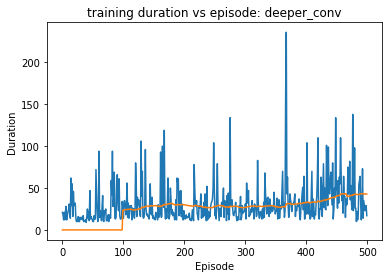

Training Completed for episods


<Figure size 432x288 with 0 Axes>

In [5]:
training(model = DQN2)


<Figure size 432x288 with 0 Axes>

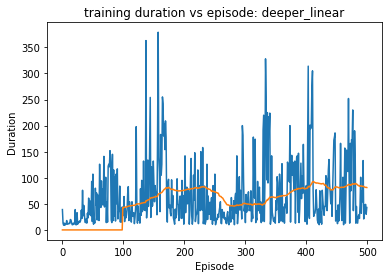

Training Completed for episods


<Figure size 432x288 with 0 Axes>

In [6]:
training(model = DQN3)


# Param tuning

There are many parameters which is able to tune. (here we use epsilon-greedy method)
- Gamma: the discount of reward in the future
- The decaying function of eps_threshold (decaying factor larger: decaying is slower)

## tuning Gamma

In [12]:
np.arange(0.5, 1, 0.1)

array([0.5, 0.6, 0.7, 0.8, 0.9])

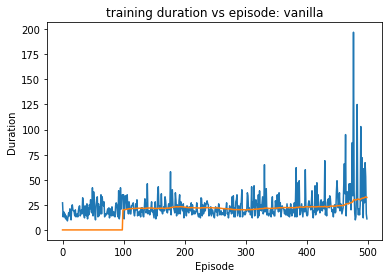

Training Completed for episods


In [2]:
training(GAMMA=0.5)

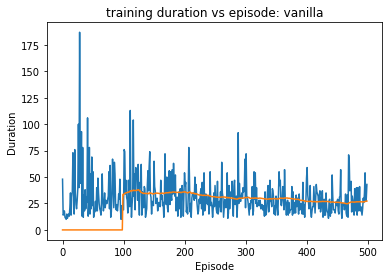

Training Completed for episods


In [3]:
training(GAMMA=0.6)

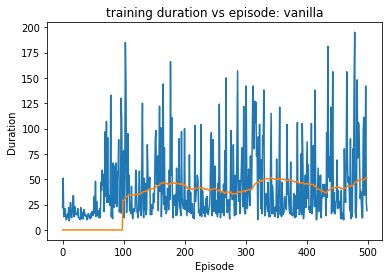

Training Completed for episods


In [4]:
training(GAMMA=0.7)

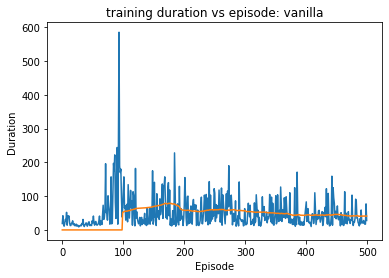

Training Completed for episods


In [5]:
training(GAMMA=0.8)

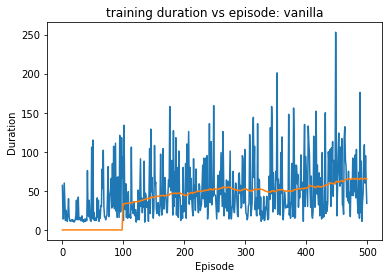

Training Completed for episods


In [6]:
training(GAMMA=0.9)

## Tuning Decay rate

decaying rate is related to the total number of episode! (So keep 500 as max of n_episode)

In [9]:
import numpy as np

In [10]:
np.arange(1, 1000, 100)

array([  1, 101, 201, 301, 401, 501, 601, 701, 801, 901])

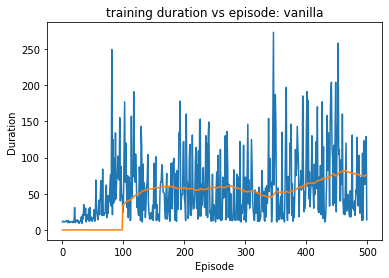

Training Completed for episods


In [11]:
training(EPS_DECAY = 1)

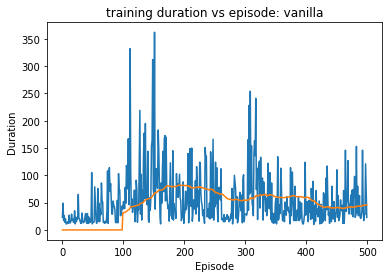

Training Completed for episods


In [12]:
training(EPS_DECAY = 100)

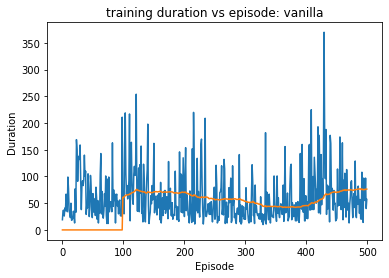

Training Completed for episods


In [13]:
training(EPS_DECAY = 200)

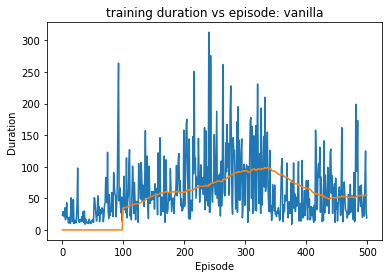

Training Completed for episods


In [14]:
training(EPS_DECAY = 1000)

# Show video

Here you can change the pth file which yield from DQN1 (max-pooling version of CNN) to play other videos
- but I only show one here
- if you intend to play others, please make sure you change DQN structure as well

In [46]:
pth_file = 'DQN_target_max_pooling5.pth'

In [47]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display as ipythondisplay # to avoid conflict with the ``display" above
plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [48]:
env = gym.make('CartPole-v0').unwrapped
env.reset()


array([ 0.01796798, -0.04674956, -0.03696259, -0.04541975])

In [49]:

def get_cart_location(screen_width):
    world_width = env.x_threshold * 2 # env location values are centered at 0, so multiplied by 2 to get the whole length
    scale = screen_width / world_width # find scale
    return int(env.state[0] * scale + screen_width / 2.0) # MIDDLE OF CART

def get_screen():

    screen = env.render(mode='rgb_array') # 400x600x3 tensor
    # Cart is in the lower half, so strip off the top and bottom of the screen
    screen_height, screen_width, _ = screen.shape
    screen = screen[int(screen_height*0.4):int(screen_height * 0.8),:,:]

    # get the cart location -- MIDDLE POINT OF CART   
    cart_location = get_cart_location(screen_width)

    # Strip off the edges, so that we have a rectangle image (160x180) centered on a cart
    view_width = int(screen_width * 0.3)
    if cart_location-view_width//2 < 0:
        slice_range = slice(view_width)
    elif cart_location+view_width//2 > screen_width:
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location-view_width//2, cart_location+view_width//2)

    screen = screen[:,slice_range,:]

    # Convert to float, rescale, convert to torch tensor
    screen = screen.astype(np.float32)/255
    screen = screen.transpose((2,0,1))
    screen = torch.from_numpy(screen)

    # furthur down sizing the screen
    resize = T.Compose([T.ToPILImage(),
                    T.Resize(size=40, interpolation=Image.BICUBIC),
                    T.ToTensor()])
    screen = resize(screen).unsqueeze(0)
    return screen

In [50]:
init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape # get screen height and width
n_actions = env.action_space.n
env.close()

In [51]:
# load model
policy_net = DQN1(screen_height,screen_width,n_actions).to(device)
policy_net.load_state_dict(torch.load(pth_file,map_location=torch.device(device)))

def wrap_env(env):
  env = gym.wrappers.Monitor(env, './video', force=True)
  return env
env = wrap_env(gym.make("CartPole-v0").unwrapped)
env.reset()
last_screen = get_screen()
current_screen = get_screen()
state = current_screen-last_screen
steps_count = 0 # step counter
# start the game of this episode
while True:
    action = policy_net(state).max(dim=1)[1].view(1,1)
    steps_count += 1 # for episode duration
    _, _, done, _ = env.step(action.item())

    # Observe new state
    last_screen = current_screen
    current_screen = get_screen()
    if not done:
        next_state = current_screen - last_screen
    else:
        next_state = None

    # Move to the next state
    state = next_state

    if done:
        print("This episode's total reward is {}".format(steps_count))
        # break out of while loop
        env.close()
        break

This episode's total reward is 22


/home/dalab5/miniconda3/lib/python3.7/site-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [52]:
env.close()

In [53]:
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
"""
Copy a utility function to display the video.
"""
def show_video():
  mp4list = glob.glob('./video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                  controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    
show_video()